In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

def plot_hangar_box(ax: plt.Axes, style = 'k--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741, 0.834
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'hangar region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right


def load_filtered_data(file_path, x_start=-0.870):
    df = pd.read_csv(file_path, header=None, skiprows=1)
    t_start = df[0].iloc[-1]
    df = df.iloc[:-1]
    df = df[df[0] > t_start]
    df = df[df[1] > x_start]
    return df

figure, ax = plt.subplots(figsize=(7,3))

plot_hangar_box(ax)

for csv_file in glob.glob('./data/high/*.csv'):
    df = load_filtered_data(csv_file)
    # ax.scatter(df[1], df[3], s=2, label=csv_file.split('/')[-1])
    ax.plot(df[1], df[3], label=csv_file.split('/')[-1])

# for csv_file in glob.glob('./data/middle/*.csv'):
#     df = load_filtered_data(csv_file)
#     ax.scatter(df[1], df[3], s=2, label=csv_file.split('/')[-1])

# for csv_file in glob.glob('./data/low/*.csv'):
#     df = load_filtered_data(csv_file)
#     # ax.scatter(df[1], df[3], s=2, label=csv_file.split('/')[-1])
#     ax.plot(df[1], df[3], label=csv_file.split('/')[-1])


plt.xlabel('x')
plt.ylabel('z')
plt.title('x-z Visualization')
# plt.legend()
plt.grid(True)
plt.xlim(-0.9, 0.5)
plt.ylim(0.5, 1.1)
# plt.axis('equal')
plt.show()

## Single Mean and Std

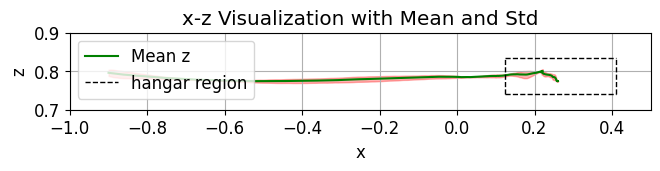

Plot saved to trajectory_plot.pdf


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import uav_trajectory


def plot_hangar_box(ax: plt.Axes, style = 'k--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741, 0.834
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'hangar region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right

def load_filtered_data(file_path, x_start=-0.870):
    ''' Load and filter data from a CSV file.'''
    df = pd.read_csv(file_path, header=None, skiprows=1)
    t_start = df[0].iloc[-1]
    df = df.iloc[:-1]
    df = df[df[0] > t_start]
    df = df[df[1] > x_start]
    # df = df[(df[1] > x_start) & (df[0] > t_start)]
    return df

def load_and_filter_trajectories(file_pattern, x_start=-0.90):
    '''
    Load and filter trajectory data from CSV files.
    
    Args:
        file_pattern (str): Glob pattern for CSV files (e.g., './data/middle/*.csv').
        x_start (float): Threshold for filtering x values.
    
    Returns:
        list: Lists of t, x, z arrays for each valid trajectory.
    '''
    all_t, all_x, all_z = [], [], []
    
    for csv_file in glob.glob(file_pattern):
        try:
            df = load_filtered_data(csv_file, x_start=x_start)
            
            if df.empty:
                print(f"{csv_file} -> Empty data, skipping")
                continue

            t = df[0].to_numpy() - df[0].iloc[0]  # Align time to 0
            x = df[1].to_numpy()
            z = df[3].to_numpy()
            all_t.append(t)
            all_x.append(x)
            all_z.append(z)

        except Exception as e:
            print(f"Error processing {csv_file}: {e}")
            continue
            
    return all_t, all_x, all_z

def interpolate_trajectories(all_t, all_x, all_z, num_points=500):
    '''
    Interpolate trajectories to a common time grid and compute mean/std.
    
    Args:
        all_t (list): List of time arrays.
        all_x (list): List of x-coordinate arrays.
        all_z (list): List of z-coordinate arrays.
        num_points (int): Number of points for interpolation.
    
    Returns:
        tuple: Common time grid, mean and std for x and z.
    '''
    t_min = max(t[0] for t in all_t)
    t_max = min(t[-1] for t in all_t)
    t_common = np.linspace(t_min, t_max, num_points)
    
    x_interp_all = [np.interp(t_common, t, x) for t, x in zip(all_t, all_x)]
    z_interp_all = [np.interp(t_common, t, z) for t, z in zip(all_t, all_z)]
    
    x_interp_all = np.array(x_interp_all)
    z_interp_all = np.array(z_interp_all)
    
    x_mean = np.mean(x_interp_all, axis=0)
    x_std = np.std(x_interp_all, axis=0)
    z_mean = np.mean(z_interp_all, axis=0)
    z_std = np.std(z_interp_all, axis=0)
    
    return t_common, x_mean, x_std, z_mean, z_std

def plot_waypoints(ax: plt.Axes, waypoints_path: str, val_filter: float = -0.877):
    '''
    Plot waypoints from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        waypoints_path (str): Path to the waypoints CSV file.
        val_filter (float): Value threshold for filtering the trajectory data.
    '''
    waypoints = np.loadtxt(waypoints_path, delimiter=",")
    mask = waypoints[:, 0] > val_filter
    ax.scatter(waypoints[mask, 0], waypoints[mask, 2], c="red", marker="o", s=20, label="Waypoints")


def plot_polynomial_trajectory(ax: plt.Axes, trajectory_path: str, val_filter: float = -0.877, style: str = "b-", label: str = ""):
    '''
    Plot the commanded trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        trajectory_path (str): Path to the trajectory CSV file.
        val_filter (float): Value threshold for filtering the trajectory data.
    '''
    traj = uav_trajectory.Trajectory()
    traj.loadcsv(trajectory_path)
    ts = np.arange(0, traj.duration, 0.01)
    evals = np.empty((len(ts), 15))
    for t, i in zip(ts, range(0, len(ts))):
        e = traj.eval(t)
        evals[i, 0:3] = e.pos
        evals[i, 3:6] = e.vel
        evals[i, 6:9] = e.acc
        evals[i, 9:12] = e.omega
        evals[i, 12] = e.yaw
        evals[i, 13] = e.roll
        evals[i, 14] = e.pitch
    mask = evals[:, 0] > val_filter
    ax.plot(evals[mask, 0], evals[mask, 2], style,label="Commanded trajectory", color="blue", linewidth=0.5)

def plot_actual_trajectory(ax: plt.Axes, csv_file: str, val_filter: float = -0.877):
    '''
    Plot the actual trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        csv_file (str): Path to the actual trajectory CSV file.
        val_filter (float): Value threshold for filtering the trajectory data.
    '''
    for i, csv_file in enumerate(glob.glob(csv_file)):
        df = load_filtered_data(csv_file, VAL_FILTER)
        if i == 0:
            ax.plot(df[1], df[3], color='g', alpha=0.5, label='Actual trajectories')
        else:
            ax.plot(df[1], df[3], color='g', alpha=0.5, label='_nolegend_')


if __name__ == '__main__':

    file_pattern = './data/middle/*.csv'
    x_threshold = -0.90
    num_points = 500

    all_t, all_x, all_z = load_and_filter_trajectories(file_pattern, x_threshold)

    t_common, x_mean, x_std, z_mean, z_std = interpolate_trajectories(all_t, all_x, all_z, num_points)

    
    plt.figure(figsize=(7.5, 1))
    plt.rcParams.update({'font.size': 12})  # Set global font size
    plt.plot(x_mean, z_mean, color='green', label='Mean z')
    plt.fill_between(x_mean, z_mean - z_std, z_mean + z_std, color='red', alpha=0.3)
    
    plot_hangar_box(plt.gca())
    
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('x-z Visualization with Mean and Std')
    plt.grid(True)
    plt.xlim(-1.0, 0.5)
    plt.ylim(0.7, 0.9)
    plt.legend(loc = 'upper left')

    output_file = 'trajectory_plot.pdf'
    dpi = 300
    plt.savefig(output_file, format='pdf', dpi=dpi, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Plot saved to {output_file}")


## Radar Plot

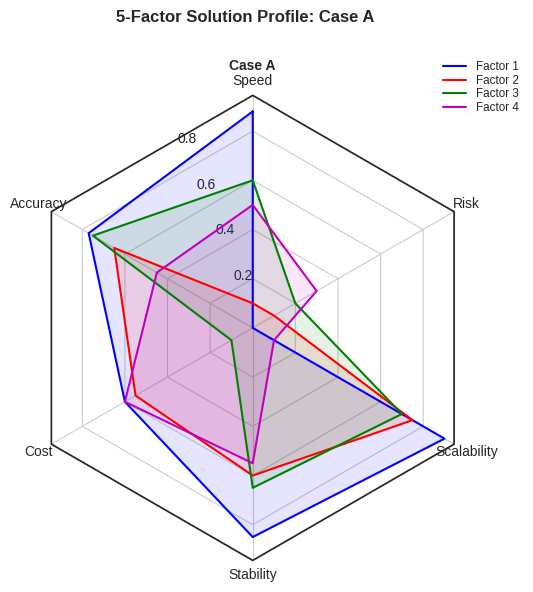

In [29]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def example_data():
    data = [
        ['Speed', 'Accuracy', 'Cost', 'Stability', 'Scalability', 'Risk'],
        ('Case A', [
            [0.88, 0.77, 0.60, 0.85, 0.90,0.0],
            [0.10, 0.65, 0.55, 0.60, 0.75,0.1],
            [0.60, 0.75, 0.10, 0.65, 0.70,0.2],
            [0.50, 0.45, 0.60, 0.55, 0.10,0.3],
        ])
    ]
    return data

if __name__ == '__main__':

    # 设置角度维度数
    N = 6
    theta = radar_factory(N, frame='polygon')

    # 获取数据
    data = example_data()
    spoke_labels = data.pop(0)

    fig, ax = plt.subplots(figsize=(6, 6), nrows=1, ncols=1,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm']
    title, case_data = data[0]
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                horizontalalignment='center', verticalalignment='center')

    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.1, label='_nolegend_')
    ax.set_varlabels(spoke_labels)

    labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4')
    ax.legend(labels, loc=(0.9, .95), labelspacing=0.15, fontsize='small')

    plt.suptitle('5-Factor Solution Profile: ' + title, weight='bold', size='large')

    plt.show()

## Watch Digram

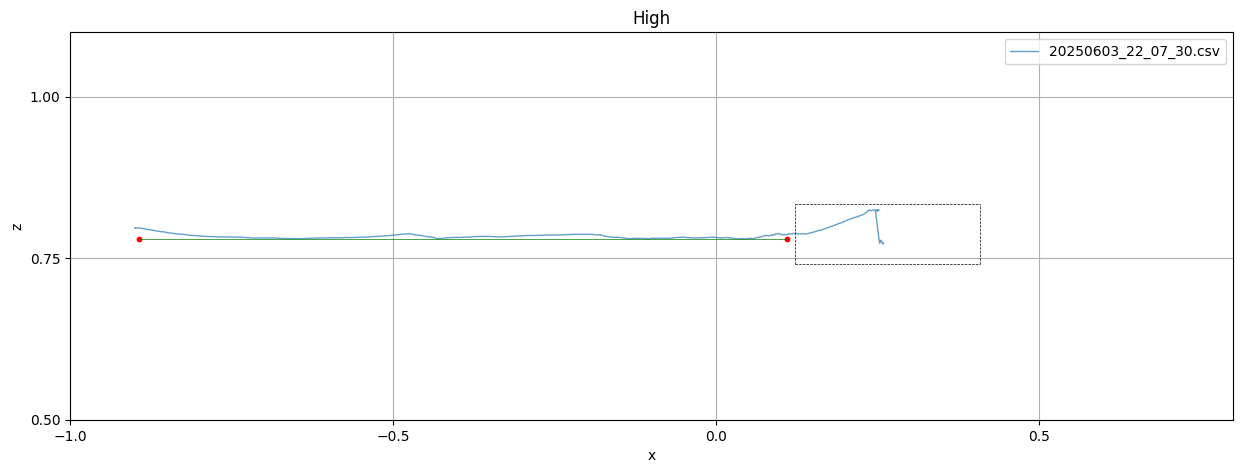

Plot saved to trajectory_plot2.pdf


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import uav_trajectory

def load_filtered_data(file_path, x_start=-0.870):
    df = pd.read_csv(file_path, header=None, skiprows=1)
    t_start = df[0].iloc[-1]
    df = df.iloc[:-1]
    df = df[df[0] > t_start]
    df = df[df[1] > x_start]
    return df



def plot_hangar_box(ax: plt.Axes):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741, 0.834
    ax.plot([x_min, x_max], [z_min, z_min], 'k--', linewidth=0.5, label = 'hangar region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], 'k--', linewidth=0.5)  # Top
    ax.plot([x_min, x_min], [z_min, z_max], 'k--', linewidth=0.5)  # Left
    ax.plot([x_max, x_max], [z_min, z_max], 'k--', linewidth=0.5)  # Right



if __name__ == '__main__':
     
    x_threshold = -0.90


    fig, ax = plt.subplots(figsize=(15,7))

    # 使用colormap自动分配颜色
    csv_files = glob.glob('./data/ablation/PPBC_copy/*.csv')
    num_files = len(csv_files)
    cmap = plt.get_cmap('tab20')  # 也可以用 'tab10', 'hsv', 'rainbow' 等

    for idx, csv_file in enumerate(csv_files):
        df = load_filtered_data(csv_file, x_threshold)
        color = cmap(idx % cmap.N)  # 防止超出colormap范围
        ax.plot(df[1], df[3], label=csv_file.split('/')[-1], linewidth=1, color=color, alpha=0.7)

    ax.legend()
    # ...existing code...

    # for csv_file in glob.glob('./data/temp/*.csv'):
    #     df = load_filtered_data(csv_file, x_start)
    #     # ax.scatter(df[1], df[3], s=2, label=csv_file.split('/')[-1])
    #     ax.plot(df[1], df[3], label=csv_file.split('/')[-1], linewidth=1, color='g', alpha=0.2)
    #     ax.legend()


    # Plot waypoints
    waypoints_path = "../data/waypoints/go_hover.csv"
    waypoints = np.loadtxt(waypoints_path, delimiter=",")
    mask = waypoints[:, 0] > x_threshold
    ax.scatter(waypoints[mask, 0], waypoints[mask, 2], c="red", marker="o", s=10)

    # Plot commanded trajectory
    traj = uav_trajectory.Trajectory()
    trajectory_path = "../data/trajectories/go_hover_traj.csv"
    traj.loadcsv(trajectory_path)
    ts = np.arange(0, traj.duration, 0.01)
    evals = np.empty((len(ts), 15))
    for t, i in zip(ts, range(0, len(ts))):
        e = traj.eval(t)
        evals[i, 0:3] = e.pos
        evals[i, 3:6] = e.vel
        evals[i, 6:9] = e.acc
        evals[i, 9:12] = e.omega
        evals[i, 12] = e.yaw
        evals[i, 13] = e.roll
        evals[i, 14] = e.pitch
    mask = evals[:, 0] > x_threshold
    ax.plot(evals[mask, 0], evals[mask, 2], label="Commanded Trajectory", color='green', linewidth=0.5)


    # # Plot desired trajectory
    # traj = uav_trajectory.Trajectory()
    # trajectory_path = "./data/trajectories/comd_high_traj.csv"
    # traj.loadcsv(trajectory_path)
    # ts = np.arange(0, traj.duration, 0.01)
    # evals = np.empty((len(ts), 15))
    # for t, i in zip(ts, range(0, len(ts))):
    #     e = traj.eval(t)
    #     evals[i, 0:3] = e.pos
    #     evals[i, 3:6] = e.vel
    #     evals[i, 6:9] = e.acc
    #     evals[i, 9:12] = e.omega
    #     evals[i, 12] = e.yaw
    #     evals[i, 13] = e.roll
    #     evals[i, 14] = e.pitch
    # mask = evals[:, 0] > x_threshold
    # ax.plot(evals[mask, 0], evals[mask, 2], label="Desired Trajectory", color='blue', linewidth=0.5)


    ax.set_aspect('equal')
    ax.set_title('High')
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.grid(True)
    ax.set_xlim(-1.0, 0.8)
    ax.set_ylim(0.5, 1.1)
    # ax.legend(loc='upper right')
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=3)
    plot_hangar_box(ax)
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(-1.0, 0.6, 0.5))
    ax.set_yticks(np.arange(0.5, 1.1, 0.25))
    # # ax.set_aspect('equal', 'box')



    output_file = 'trajectory_plot2.pdf'
    dpi = 300
    plt.savefig(output_file, format='pdf', dpi=dpi, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Plot saved to {output_file}")




## Varying Heights

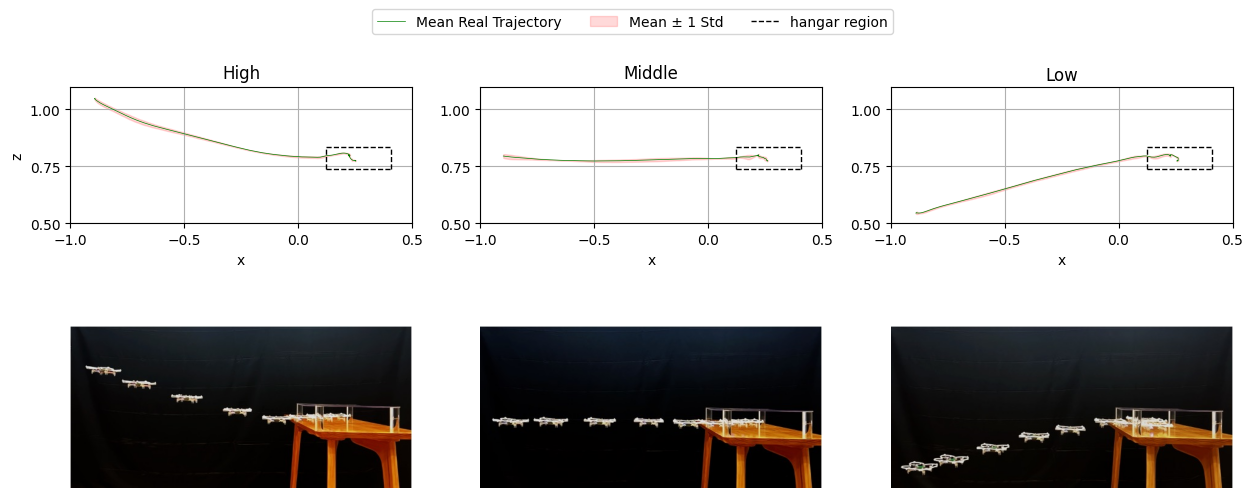

Plot saved to pdf_trajectory_plot.pdf


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import uav_trajectory

def plot_hangar_box(ax: plt.Axes, style = 'k--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741, 0.834
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'hangar region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right

def load_filtered_data(file_path, x_start=-0.870):
    ''' Load and filter data from a CSV file.'''
    df = pd.read_csv(file_path, header=None, skiprows=1)
    t_start = df[0].iloc[-1]
    df = df.iloc[:-1]
    df = df[df[0] > t_start]
    df = df[df[1] > x_start]
    # df = df[(df[1] > x_start) & (df[0] > t_start)]
    return df

def load_and_filter_trajectories(file_pattern, x_start=-0.90):
    '''
    Load and filter trajectory data from CSV files.
    
    Args:
        file_pattern (str): Glob pattern for CSV files (e.g., './data/middle/*.csv').
        x_start (float): Threshold for filtering x values.
    
    Returns:
        list: Lists of t, x, z arrays for each valid trajectory.
    '''
    all_t, all_x, all_z = [], [], []
    
    for csv_file in glob.glob(file_pattern):
        try:
            df = load_filtered_data(csv_file, x_start=x_start)
            
            if df.empty:
                print(f"{csv_file} -> Empty data, skipping")
                continue

            t = df[0].to_numpy() - df[0].iloc[0]  # Align time to 0
            x = df[1].to_numpy()
            z = df[3].to_numpy()
            all_t.append(t)
            all_x.append(x)
            all_z.append(z)

        except Exception as e:
            print(f"Error processing {csv_file}: {e}")
            continue
            
    return all_t, all_x, all_z

def interpolate_trajectories(all_t, all_x, all_z, num_points=500):
    '''
    Interpolate trajectories to a common time grid and compute mean/std.
    
    Args:
        all_t (list): List of time arrays.
        all_x (list): List of x-coordinate arrays.
        all_z (list): List of z-coordinate arrays.
        num_points (int): Number of points for interpolation.
    
    Returns:
        tuple: Common time grid, mean and std for x and z.
    '''
    t_min = max(t[0] for t in all_t)
    t_max = min(t[-1] for t in all_t)
    t_common = np.linspace(t_min, t_max, num_points)
    
    x_interp_all = [np.interp(t_common, t, x) for t, x in zip(all_t, all_x)]
    z_interp_all = [np.interp(t_common, t, z) for t, z in zip(all_t, all_z)]
    
    x_interp_all = np.array(x_interp_all)
    z_interp_all = np.array(z_interp_all)
    
    x_mean = np.mean(x_interp_all, axis=0)
    x_std = np.std(x_interp_all, axis=0)
    z_mean = np.mean(z_interp_all, axis=0)
    z_std = np.std(z_interp_all, axis=0)
    
    return t_common, x_mean, x_std, z_mean, z_std

def plot_waypoints(ax: plt.Axes, waypoints_path: str, val_filter: float = -0.877):
    '''
    Plot waypoints from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        waypoints_path (str): Path to the waypoints CSV file.
        val_filter (float): Value threshold for filtering the trajectory data.
    '''
    waypoints = np.loadtxt(waypoints_path, delimiter=",")
    mask = waypoints[:, 0] > val_filter
    ax.scatter(waypoints[mask, 0], waypoints[mask, 2], c="red", marker="o", s=20, label="Waypoints")


def plot_polynomial_trajectory(ax: plt.Axes, trajectory_path: str, val_filter: float = -0.877, style: str = "b-", label: str = ""):
    '''
    Plot the commanded trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        trajectory_path (str): Path to the trajectory CSV file.
        val_filter (float): Value threshold for filtering the trajectory data.
    '''
    traj = uav_trajectory.Trajectory()
    traj.loadcsv(trajectory_path)
    ts = np.arange(0, traj.duration, 0.01)
    evals = np.empty((len(ts), 15))
    for t, i in zip(ts, range(0, len(ts))):
        e = traj.eval(t)
        evals[i, 0:3] = e.pos
        evals[i, 3:6] = e.vel
        evals[i, 6:9] = e.acc
        evals[i, 9:12] = e.omega
        evals[i, 12] = e.yaw
        evals[i, 13] = e.roll
        evals[i, 14] = e.pitch
    mask = evals[:, 0] > val_filter
    ax.plot(evals[mask, 0], evals[mask, 2], style,label="Commanded trajectory", color="blue", linewidth=0.5)

def plot_actual_trajectory(ax: plt.Axes, csv_file: str, val_filter: float = -0.877):
    '''
    Plot the actual trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        csv_file (str): Path to the actual trajectory CSV file.
        val_filter (float): Value threshold for filtering the trajectory data.
    '''
    for i, csv_file in enumerate(glob.glob(csv_file)):
        df = load_filtered_data(csv_file, VAL_FILTER)
        if i == 0:
            ax.plot(df[1], df[3], color='g', alpha=0.5, label='Actual trajectories')
        else:
            ax.plot(df[1], df[3], color='g', alpha=0.5, label='_nolegend_')


if __name__ == '__main__':
     
    x_start = -0.90
    num_points = 500

    file_folder_high = './data/high/*.csv'
    file_folder_middle = './data/middle/*.csv'
    file_folder_low = './data/low/*.csv'

    # Load and filter trajectories
    all_t_high, all_x_high, all_z_high = load_and_filter_trajectories(file_folder_high, x_start)
    all_t_middle, all_x_middle, all_z_middle = load_and_filter_trajectories(file_folder_middle, x_start)
    all_t_low, all_x_low, all_z_low = load_and_filter_trajectories(file_folder_low, x_start)

    # Interpolate trajectories to a common time grid and compute mean/std
    t_common_high, x_mean_high, x_std_high, z_mean_high, z_std_high = interpolate_trajectories(all_t_high, all_x_high, all_z_high, num_points)
    t_common_middle, x_mean_middle, x_std_middle, z_mean_middle, z_std_middle = interpolate_trajectories(all_t_middle, all_x_middle, all_z_middle, num_points)
    t_common_low, x_mean_low, x_std_low, z_mean_low, z_std_low = interpolate_trajectories(all_t_low, all_x_low, all_z_low, num_points)



    fig, axs = plt.subplots(2, 3, figsize = (15,6))


    # =======================================================
    # High 
    # =======================================================

    axs[0,0].plot(x_mean_high, z_mean_high, color='g', label='Mean Real Trajectory', linewidth=0.5)
    axs[0,0].fill_between(x_mean_high, z_mean_high - z_std_high, z_mean_high + z_std_high, color='red', alpha=0.15, label='Mean ± 1 Std')

    # # Plot waypoints
    # waypoints_path = "./data/waypoints/final_high.csv"
    # plot_waypoints(axs[0,0], waypoints_path, val_filter=x_start)

    # # Plot commanded trajectory
    # cmd_traj_path = "./data/trajectories/final_high_traj.csv"
    # plot_trajectory(axs[0,0], cmd_traj_path, x_start)

    # # Plot desired trajectory
    # desired_traj_path = "./data/trajectories/comd_high_traj.csv"
    # plot_polynomial_trajectory(axs[0, 0], desired_traj_path, x_start)

    axs[0,0].set_title('High')
    axs[0,0].set_xlabel('x')
    axs[0,0].set_ylabel('z')
    axs[0,0].grid(True)
    axs[0,0].set_xlim(-1.0, 0.5)
    axs[0,0].set_ylim(0.5, 1.1)
    # axs[0,0].legend(loc='upper right')
    # axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=3)
    plot_hangar_box(axs[0,0])
    axs[0,0].set_aspect('equal')
    axs[0,0].set_xticks(np.arange(-1.0, 0.6, 0.5))
    axs[0,0].set_yticks(np.arange(0.5, 1.1, 0.25))
    # # axs[0,0].set_aspect('equal', 'box')

 
    # =======================================================
    # Middle
    # =======================================================

    axs[0,1].plot(x_mean_middle, z_mean_middle, color='g', label='Mean Real Trajectory', linewidth=0.5) 
    axs[0,1].fill_between(x_mean_middle, z_mean_middle - z_std_middle, z_mean_middle + z_std_middle, color='red', alpha=0.15, label='Mean ± 1 Std')

    # # Plot waypoints
    # waypoints_path = "./data/waypoints/final_middle.csv"
    # plot_waypoints(axs[0,1], waypoints_path, val_filter=x_start)

    # # Plot commanded trajectory
    # cmd_traj_path = "./data/trajectories/final_middle_traj.csv"
    # plot_trajectory(axs[0,1], cmd_traj_path, x_start)

    # # Plot desired trajectory
    # desired_traj_path = "./data/trajectories/comd_middle_traj.csv"
    # plot_polynomial_trajectory(axs[0,1], desired_traj_path, x_start)
    
    axs[0,1].set_title('Middle')
    axs[0,1].set_xlabel('x')
    axs[0,1].grid(True)
    axs[0,1].set_xlim(-1.0, 0.5)
    axs[0,1].set_ylim(0.5, 1.1)
    # axs[0,1].legend(loc='upper right')
    # axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=3)
    plot_hangar_box(axs[0,1])
    axs[0,1].set_aspect('equal')
    axs[0,1].set_xticks(np.arange(-1.0, 0.6, 0.5))
    axs[0,1].set_yticks(np.arange(0.5, 1.1, 0.25))
    # axs[0,1].set_aspect('equal', 'box')


    # =======================================================
    # Low
    # =======================================================

    axs[0,2].plot(x_mean_low, z_mean_low, color='g', label='Mean Real Trajectory', linewidth=0.5)
    axs[0,2].fill_between(x_mean_low, z_mean_low - z_std_low, z_mean_low + z_std_low, color='red', alpha=0.15, label='Mean ± 1 Std')

    # # Plot waypoints
    # waypoints_path = "./data/waypoints/final_low.csv"
    # plot_waypoints(axs[0,2], waypoints_path, val_filter=x_start)

    # # Plot commanded trajectory
    # cmd_traj_path = "./data/trajectories/final_low_traj.csv"
    # plot_trajectory(axs[0,2], cmd_traj_path, x_start)

    # # Plot desired trajectory
    # desired_traj_path = "./data/trajectories/comd_low_traj.csv"
    # plot_polynomial_trajectory(axs[0,2], desired_traj_path, x_start)

    axs[0,2].set_title('Low',y = 0.99)
    axs[0,2].set_xlabel('x')
    axs[0,2].grid(True)
    axs[0,2].set_xlim(-1.0, 0.5)
    axs[0,2].set_ylim(0.5, 1.1)  
    # axs[0,2].legend(loc='upper right')
    # axs[0,2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=3)
    plot_hangar_box(axs[0,2])
    axs[0,2].set_aspect('equal')
    axs[0,2].set_xticks(np.arange(-1.0, 0.6, 0.5))
    axs[0,2].set_yticks(np.arange(0.5, 1.1, 0.25))
    # axs[0,2].set_aspect('equal', 'box')



    img_paths = ['./data/imgs/high_snapshot.jpg', './data/imgs/middle_snapshot.jpg', './data/imgs/low_snapshot.jpg']  # 替换为你的图片路径
    for i, img_path in enumerate(img_paths):
        img = plt.imread(img_path)
        axs[1, i].imshow(img)
        axs[1, i].axis('off')
        # axs[1, i].set_title(f"Snapshot {i+1}")

    # 只收集第一行轨迹子图的 legend, 对于2行
    handles, labels = [], []
    for ax in axs[0]:  # 只遍历第一行的每个子图
        for h, l in zip(*ax.get_legend_handles_labels()):
            if l not in labels:
                handles.append(h)
                labels.append(l)

    # 添加全局 legend
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=3)


    # # 收集所有 handles 和 labels 对于1行
    # handles, labels = [], []
    # for ax in axs:
    #     for h, l in zip(*ax.get_legend_handles_labels()):
    #         if l not in labels:
    #             handles.append(h)
    #             labels.append(l)
    
    # # 添加全局 legend
    # fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.92), ncol=3)
    
    # # suptitle 稍微往上移
    # plt.suptitle('Mean and Std of z vs x for Different Trajectory Heights', fontsize=16, y=1.03)
    # plt.tight_layout(rect=[0, 0, 1, 0.90])  # 留出 legend 空间

    # plt.tight_layout()
    # plt.suptitle('Mean and Std of z vs x for Different Trajectory Heights', fontsize=16)
    # plt.subplots_adjust(hspace=0.0,)  # Adjust top to make room for the title
    # plt.show() 

    # Save as PDF
    output_file = 'pdf_trajectory_plot.pdf'
    dpi = 300
    plt.savefig(output_file, format='pdf', dpi=dpi, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Plot saved to {output_file}")


### Varying Heights Output

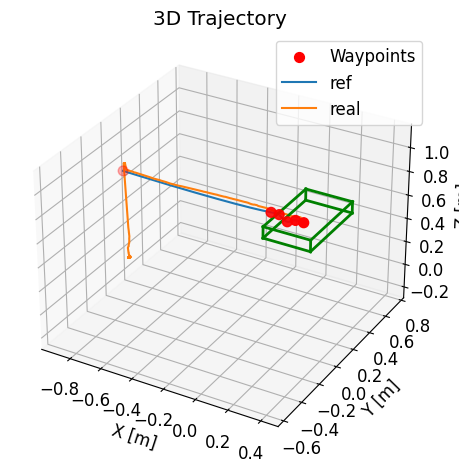

In [27]:
#!/usr/bin/env python

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import argparse

import uav_trajectory
import pandas as pd


def load_filtered_data(file_path):
    """
    Load and filter the trajectory data from a CSV file.
    Args:
        file_path (str): Path to the CSV file containing trajectory data.
    Returns:
        pd.DataFrame: Filtered trajectory data excluding the last row and with x > -0.877.
    """
    df = pd.read_csv(file_path, header=None, skiprows=1)

    filtered_data = df.iloc[:-1]  # Skip the last row. It records the time when the trajectory starts to execute.
    # last_time = df.iloc[-1, 0]
    # filtered_data = filtered_data[filtered_data[0] > last_time]

    x_start = -0.877
    filtered_data = filtered_data[filtered_data[1] > x_start]

    return filtered_data


if __name__ == "__main__":

    fig_3d = plt.figure()
    ax_3d = fig_3d.add_subplot(111, projection="3d")


    # Plot waypoints
    waypoints_path = "./data/waypoints/final_middle.csv"
    waypoints = np.loadtxt(waypoints_path, delimiter=",")
    ax_3d.scatter(waypoints[:, 0], waypoints[:, 1], waypoints[:, 2], c="red", marker="o", s=50, label="Waypoints")


    # Plot commanded trajectory
    traj = uav_trajectory.Trajectory()
    trajectory_path = "./data/trajectories/final_middle_traj.csv"
    traj.loadcsv(trajectory_path)
    ts = np.arange(0, traj.duration, 0.01)
    evals = np.empty((len(ts), 15))
    for t, i in zip(ts, range(0, len(ts))):
        e = traj.eval(t)
        evals[i, 0:3] = e.pos
        evals[i, 3:6] = e.vel
        evals[i, 6:9] = e.acc
        evals[i, 9:12] = e.omega
        evals[i, 12] = e.yaw
        evals[i, 13] = e.roll
        evals[i, 14] = e.pitch
    ax_3d.plot(evals[:, 0], evals[:, 1], evals[:, 2], label="ref")  # 绘制轨迹


    # Plot real trajectory   
    real_data_path = "./data/varying_height/middle/20250604_16_30_31.csv"
    real_data = load_filtered_data(real_data_path)
    real_data_np = real_data.to_numpy()  # 转为 numpy 数组
    ax_3d.plot(real_data_np[:, 1], real_data_np[:, 2], real_data_np[:, 3], label="real")
    # ax_3d.plot(real_data[:, 1], real_data[:, 2], real_data[:, 3], label="real")  # 绘制轨迹

    # 绘制立方体方框
    x_min, x_max = 0.155-0.032, 0.377+0.032
    y_min, y_max = -0.122-0.032, 0.293+0.032
    z_min, z_max = 0.741, 0.834

    # 8个顶点
    corners = np.array([
        [x_min, y_min, z_min],
        [x_max, y_min, z_min],
        [x_max, y_max, z_min],
        [x_min, y_max, z_min],
        [x_min, y_min, z_max],
        [x_max, y_min, z_max],
        [x_max, y_max, z_max],
        [x_min, y_max, z_max],
    ])

    # 12条棱，每条棱由两个顶点组成
    edges = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # 底面
        [4, 5], [5, 6], [6, 7], [7, 4],  # 顶面
        [0, 4], [1, 5], [2, 6], [3, 7],  # 侧面
    ]

    for edge in edges:
        ax_3d.plot(
            [corners[edge[0], 0], corners[edge[1], 0]],
            [corners[edge[0], 1], corners[edge[1], 1]],
            [corners[edge[0], 2], corners[edge[1], 2]],
            c="g", linewidth=2, label=None
        )

    ax_3d.set_xlabel("X [m]")  # 设置 X 轴标签
    ax_3d.set_ylabel("Y [m]")  # 设置 Y 轴标签
    ax_3d.set_zlabel("Z [m]")  # 设置 Z 轴标签
    ax_3d.set_title("3D Trajectory")  # 设置标题
    ax_3d.legend()

    # 设置所有轴的比例相同
    x_limits = ax_3d.get_xlim()
    y_limits = ax_3d.get_ylim()
    z_limits = ax_3d.get_zlim()

    max_range = max(
        x_limits[1] - x_limits[0],
        y_limits[1] - y_limits[0],
        z_limits[1] - z_limits[0],
    ) / 2.0

    x_mid = (x_limits[0] + x_limits[1]) / 2.0
    y_mid = (y_limits[0] + y_limits[1]) / 2.0
    z_mid = (z_limits[0] + z_limits[1]) / 2.0

    ax_3d.set_xlim([x_mid - max_range, x_mid + max_range])
    ax_3d.set_ylim([y_mid - max_range, y_mid + max_range])
    ax_3d.set_zlim([z_mid - max_range, z_mid + max_range])

    plt.tight_layout()
    plt.show()

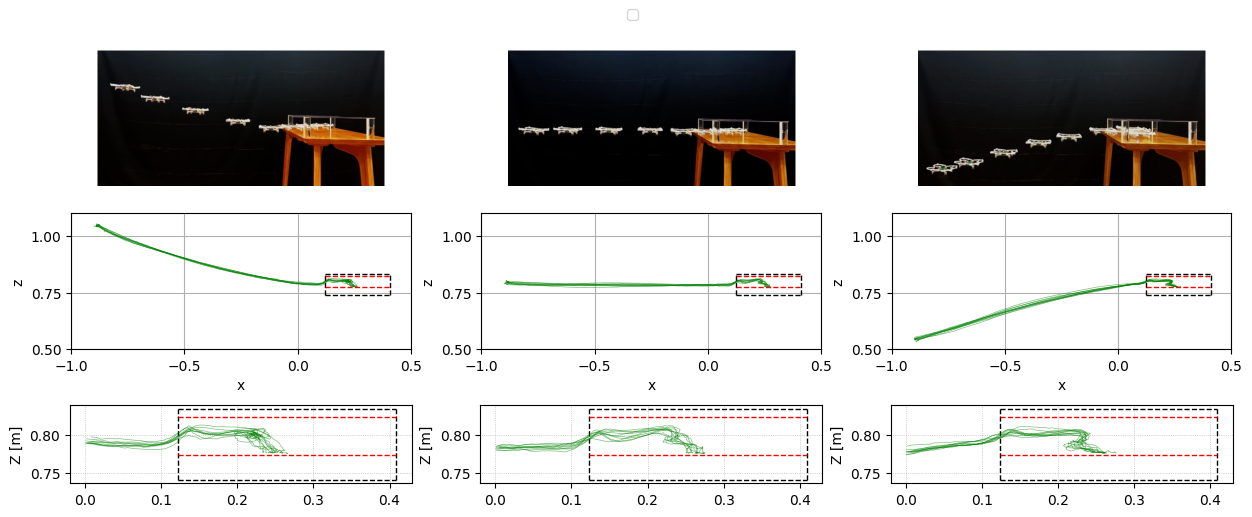

Plot saved to pdf_varying_height_plot.pdf


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import uav_trajectory

def plot_hangar_box(ax: plt.Axes, style = 'k--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741, 0.834
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'hangar region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right

def plot_safe_barrier(ax: plt.Axes, style = 'r--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741+0.033, 0.834-0.011
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'safe region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    # ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    # ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right

def load_filtered_data(file_path, x_start=-0.870):
    ''' Load and filter data from a CSV file.'''
    df = pd.read_csv(file_path, header=None, skiprows=1)
    t_start = df[0].iloc[-1]
    df = df.iloc[:-1]
    df = df[df[0] > t_start]
    df = df[df[1] > x_start]
    # df = df[(df[1] > x_start) & (df[0] > t_start)]
    return df

def plot_waypoints(ax: plt.Axes, waypoints_path: str, x_start: float = -0.877):
    '''
    Plot waypoints from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        waypoints_path (str): Path to the waypoints CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    waypoints = np.loadtxt(waypoints_path, delimiter=",")
    mask = waypoints[:, 0] > x_start
    ax.scatter(waypoints[mask, 0], waypoints[mask, 2], c="red", marker="o", s=20, label="Waypoints")


def plot_polynomial_trajectory(ax: plt.Axes, trajectory_path: str, x_start: float = -0.877, style: str = "b-", label: str = ""):
    '''
    Plot the commanded trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        trajectory_path (str): Path to the trajectory CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    traj = uav_trajectory.Trajectory()
    traj.loadcsv(trajectory_path)
    ts = np.arange(0, traj.duration, 0.01)
    evals = np.empty((len(ts), 15))
    for t, i in zip(ts, range(0, len(ts))):
        e = traj.eval(t)
        evals[i, 0:3] = e.pos
        evals[i, 3:6] = e.vel
        evals[i, 6:9] = e.acc
        evals[i, 9:12] = e.omega
        evals[i, 12] = e.yaw
        evals[i, 13] = e.roll
        evals[i, 14] = e.pitch
    mask = evals[:, 0] > x_start
    ax.plot(evals[mask, 0], evals[mask, 2], style,label="Commanded trajectory", color="blue", linewidth=0.5)

def plot_actual_trajectory(ax: plt.Axes, csv_file: str, x_start: float = -0.877):
    '''
    Plot the actual trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        csv_file (str): Path to the actual trajectory CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    for i, csv_file in enumerate(glob.glob(csv_file)):
        df = load_filtered_data(csv_file, x_start)
        if i == 0:
            ax.plot(df[1], df[3], color='g', alpha=0.5, label='Actual trajectories', linewidth=0.5)
        else:
            ax.plot(df[1], df[3], color='g', alpha=0.5, label='_nolegend_',linewidth=0.5)


if __name__ == '__main__':
     
    x_start = -0.90
    fig, axs = plt.subplots(3, 3, figsize = (15,6),)

    # =======================================================
    # High 
    # =======================================================
    
    act_traj_path = './data/varying_height/high/*.csv'
    i,j = 1,0
    plot_actual_trajectory(axs[i,j], act_traj_path, x_start)
    axs[i,j].set_xlabel('x')
    axs[i,j].set_ylabel('z')
    axs[i,j].grid(True)
    axs[i,j].set_xlim(-1.0, 0.5)
    axs[i,j].set_ylim(0.5, 1.1)
    # axs[i,j].legend(loc='upper right')
    # axs[i,j].legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=3)
    plot_hangar_box(axs[i,j])
    plot_safe_barrier(axs[i,j])
    axs[i,j].set_aspect('equal')
    axs[i,j].set_xticks(np.arange(-1.0, 0.6, 0.5))
    axs[i,j].set_yticks(np.arange(0.5, 1.1, 0.25))
    # # axs[i,j].set_aspect('equal', 'box')

    plot_hangar_box(axs[2,j])
    plot_safe_barrier(axs[2,j])
    plot_actual_trajectory(axs[2,j], act_traj_path, 0.0)
    # axs[2,j].set_xlabel("X [m]")
    axs[2,j].set_ylabel("Z [m]")
    # axs[2,j].set_title("Proposed Path + Proposed Controller", fontsize=10)
    axs[2,j].grid(linestyle=':', linewidth=0.5)
    axs[2,j].set_aspect('equal')

 
    # =======================================================
    # Middle
    # =======================================================


    act_traj_path = './data/varying_height/middle/*.csv'
    i,j = 1,1
    plot_actual_trajectory(axs[i,j], act_traj_path, x_start)
    axs[i,j].set_xlabel('x')
    axs[i,j].set_ylabel('z')
    axs[i,j].grid(True)
    axs[i,j].set_xlim(-1.0, 0.5)
    axs[i,j].set_ylim(0.5, 1.1)
    # axs[i,j].legend(loc='upper right')
    # axs[i,j].legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=3)
    plot_hangar_box(axs[i,j])
    plot_safe_barrier(axs[i,j])
    axs[i,j].set_aspect('equal')
    axs[i,j].set_xticks(np.arange(-1.0, 0.6, 0.5))
    axs[i,j].set_yticks(np.arange(0.5, 1.1, 0.25))
    # # axs[i,j].set_aspect('equal', 'box')

    plot_hangar_box(axs[2,j])
    plot_safe_barrier(axs[2,j])
    plot_actual_trajectory(axs[2,j], act_traj_path, 0.0)
    # axs[2,j].set_xlabel("X [m]")
    axs[2,j].set_ylabel("Z [m]")
    # axs[2,j].set_title("Proposed Path + Proposed Controller", fontsize=10)
    axs[2,j].grid(linestyle=':', linewidth=0.5)
    axs[2,j].set_aspect('equal')


    # =======================================================
    # Low
    # =======================================================

    act_traj_path = './data/varying_height/low/*.csv'
    i,j = 1,2
    plot_actual_trajectory(axs[i,j], act_traj_path, x_start)
    axs[i,j].set_xlabel('x')
    axs[i,j].set_ylabel('z')
    axs[i,j].grid(True)
    axs[i,j].set_xlim(-1.0, 0.5)
    axs[i,j].set_ylim(0.5, 1.1)
    # axs[i,j].legend(loc='upper right')
    # axs[i,j].legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=3)
    plot_hangar_box(axs[i,j])
    plot_safe_barrier(axs[i,j])
    axs[i,j].set_aspect('equal')
    axs[i,j].set_xticks(np.arange(-1.0, 0.6, 0.5))
    axs[i,j].set_yticks(np.arange(0.5, 1.1, 0.25))
    # # axs[i,j].set_aspect('equal', 'box'))

    plot_hangar_box(axs[2,j])
    plot_safe_barrier(axs[2,j])
    plot_actual_trajectory(axs[2,j], act_traj_path, 0.0)
    # axs[2,j].set_xlabel("X [m]")
    axs[2,j].set_ylabel("Z [m]")
    # axs[2,j].set_title("Proposed Path + Proposed Controller", fontsize=10)
    axs[2,j].grid(linestyle=':', linewidth=0.5)
    axs[2,j].set_aspect('equal')



    img_paths = ['./data/imgs/high_snapshot.jpg', './data/imgs/middle_snapshot.jpg', './data/imgs/low_snapshot.jpg']  # 替换为你的图片路径
    for i, img_path in enumerate(img_paths):
        img = plt.imread(img_path)
        axs[0, i].imshow(img)
        axs[0, i].axis('off')
        # axs[1, i].set_title(f"Snapshot {i+1}")

    # 只收集第一行轨迹子图的 legend, 对于2行
    handles, labels = [], []
    for ax in axs[0]:  # 只遍历第一行的每个子图
        for h, l in zip(*ax.get_legend_handles_labels()):
            if l not in labels:
                handles.append(h)
                labels.append(l)

    # 添加全局 legend
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=3)


    # Save as PDF
    output_file = 'pdf_varying_height_plot.pdf'
    dpi = 300
    plt.savefig(output_file, format='pdf', dpi=dpi, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Plot saved to {output_file}")


## Varying Hight, all data, vertical

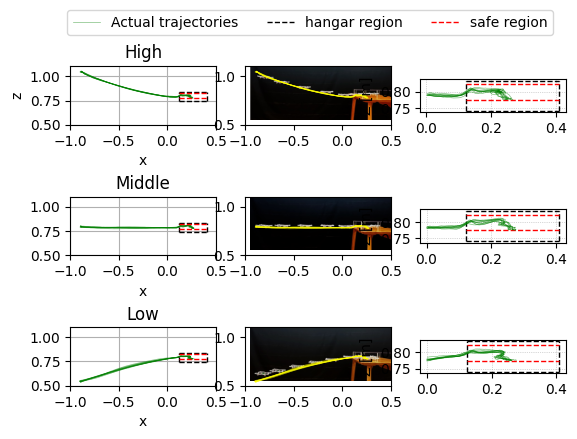

Plot saved to pdf_varying_height_plot.pdf


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import uav_trajectory

def plot_hangar_box(ax: plt.Axes, style = 'k--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741, 0.834
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'hangar region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right

def plot_safe_barrier(ax: plt.Axes, style = 'r--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741+0.033, 0.834-0.011
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'safe region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    # ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    # ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right

def load_filtered_data(file_path, x_start=-0.870):
    ''' Load and filter data from a CSV file.'''
    df = pd.read_csv(file_path, header=None, skiprows=1)
    t_start = df[0].iloc[-1]
    df = df.iloc[:-1]
    df = df[df[0] > t_start]
    df = df[df[1] > x_start]
    # df = df[(df[1] > x_start) & (df[0] > t_start)]
    return df

def plot_waypoints(ax: plt.Axes, waypoints_path: str, x_start: float = -0.877):
    '''
    Plot waypoints from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        waypoints_path (str): Path to the waypoints CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    waypoints = np.loadtxt(waypoints_path, delimiter=",")
    mask = waypoints[:, 0] > x_start
    ax.scatter(waypoints[mask, 0], waypoints[mask, 2], c="red", marker="o", s=20, label="Waypoints")


def plot_polynomial_trajectory(ax: plt.Axes, trajectory_path: str, x_start: float = -0.877, style: str = "b-", label: str = ""):
    '''
    Plot the commanded trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        trajectory_path (str): Path to the trajectory CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    traj = uav_trajectory.Trajectory()
    traj.loadcsv(trajectory_path)
    ts = np.arange(0, traj.duration, 0.01)
    evals = np.empty((len(ts), 15))
    for t, i in zip(ts, range(0, len(ts))):
        e = traj.eval(t)
        evals[i, 0:3] = e.pos
        evals[i, 3:6] = e.vel
        evals[i, 6:9] = e.acc
        evals[i, 9:12] = e.omega
        evals[i, 12] = e.yaw
        evals[i, 13] = e.roll
        evals[i, 14] = e.pitch
    mask = evals[:, 0] > x_start
    ax.plot(evals[mask, 0], evals[mask, 2], style,label="Commanded trajectory", color="blue", linewidth=0.5)

def plot_actual_trajectory(ax: plt.Axes, csv_file: str, x_start: float = -0.877, color='g'):
    '''
    Plot the actual trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        csv_file (str): Path to the actual trajectory CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    for i, csv_file in enumerate(glob.glob(csv_file)):
        df = load_filtered_data(csv_file, x_start)
        if i == 0:
            ax.plot(df[1], df[3], color=color, alpha=0.5, label='Actual trajectories', linewidth=0.5)
        else:
            ax.plot(df[1], df[3], color=color, alpha=0.5, label='_nolegend_',linewidth=0.5)


if __name__ == '__main__':
     
    x_start = -0.90
    fig, axs = plt.subplots(3, 3)

    # =======================================================
    # High 
    # =======================================================

    act_traj_path = './data/varying_height/high/*.csv'
    plot_actual_trajectory(axs[0,0], act_traj_path, x_start)

    axs[0,0].set_title('High')
    axs[0,0].set_xlabel('x')
    axs[0,0].set_ylabel('z')
    axs[0,0].grid(True)
    axs[0,0].set_xlim(-1.0, 0.5)
    axs[0,0].set_ylim(0.5, 1.1)
    # axs[0,0].legend(loc='upper right')
    # axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=3)
    plot_hangar_box(axs[0,0])
    plot_safe_barrier(axs[0,0])
    axs[0,0].set_aspect('equal')
    axs[0,0].set_xticks(np.arange(-1.0, 0.6, 0.5))
    axs[0,0].set_yticks(np.arange(0.5, 1.1, 0.25))
    # # axs[0,0].set_aspect('equal', 'box')

    plot_hangar_box(axs[0,2])
    plot_safe_barrier(axs[0,2])
    plot_actual_trajectory(axs[0,2], act_traj_path, 0.0)
    # axs[0,2].set_xlabel("X [m]")
    axs[0,2].set_ylabel("Z [m]")
    # axs[0,2].set_title("Proposed Path + Proposed Controller", fontsize=10)
    axs[0,2].grid(linestyle=':', linewidth=0.5)
    axs[0,2].set_aspect('equal')

 
    # =======================================================
    # Middle
    # =======================================================

    act_traj_path = './data/varying_height/middle/*.csv'
    plot_actual_trajectory(axs[1,0], act_traj_path, x_start)
    
    axs[1,0].set_title('Middle')
    axs[1,0].set_xlabel('x')
    axs[1,0].grid(True)
    axs[1,0].set_xlim(-1.0, 0.5)
    axs[1,0].set_ylim(0.5, 1.1)
    # axs[1,0].legend(loc='upper right')
    # axs[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=3)
    plot_hangar_box(axs[1,0])
    plot_safe_barrier(axs[1,0])
    axs[1,0].set_aspect('equal')
    axs[1,0].set_xticks(np.arange(-1.0, 0.6, 0.5))
    axs[1,0].set_yticks(np.arange(0.5, 1.1, 0.25))
    # axs[1,0].set_aspect('equal', 'box')

    plot_hangar_box(axs[1,2])
    plot_safe_barrier(axs[1,2])
    plot_actual_trajectory(axs[1,2], act_traj_path, 0.0)
    # axs[1,2].set_xlabel("X [m]")
    axs[1,2].set_ylabel("Z [m]")
    # axs[1,2].set_title("Proposed Path + Proposed Controller", fontsize=10)
    axs[1,2].grid(linestyle=':', linewidth=0.5)
    axs[1,2].set_aspect('equal')


    # =======================================================
    # Low
    # =======================================================

    act_traj_path = './data/varying_height/low/*.csv'
    plot_actual_trajectory(axs[2,0], act_traj_path, x_start)

    axs[2,0].set_title('Low',y = 0.99)
    axs[2,0].set_xlabel('x')
    axs[2,0].grid(True)
    axs[2,0].set_xlim(-1.0, 0.5)
    axs[2,0].set_ylim(0.5, 1.1)  
    # axs[2,0].legend(loc='upper right')
    # axs[2,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=3)
    plot_hangar_box(axs[2,0])
    plot_safe_barrier(axs[2,0])
    axs[2,0].set_aspect('equal')
    axs[2,0].set_xticks(np.arange(-1.0, 0.6, 0.5))
    axs[2,0].set_yticks(np.arange(0.5, 1.1, 0.25))
    # axs[2,0].set_aspect('equal', 'box')

    plot_hangar_box(axs[2,2])
    plot_safe_barrier(axs[2,2])
    plot_actual_trajectory(axs[2,2], act_traj_path, 0.0)
    # axs[2,2].set_xlabel("X [m]")
    axs[2,2].set_ylabel("Z [m]")
    # axs[2,2].set_title("Proposed Path + Proposed Controller", fontsize=10)
    axs[2,2].grid(linestyle=':', linewidth=0.5)
    axs[2,2].set_aspect('equal')



    # img_paths = ['./data/imgs/high_snapshot.jpg', './data/imgs/middle_snapshot.jpg', './data/imgs/low_snapshot.jpg']  # 替换为你的图片路径
    # for i, img_path in enumerate(img_paths):
    #     img = plt.imread(img_path)
    #     axs[i,1].imshow(img)
        # axs[i,1].axis('off')
        # axs[i,1].set_title(f"Snapshot {i+1}")

    for i, img_path in enumerate(img_paths):
        img = plt.imread(img_path)

        # 设置图片坐标系，和轨迹图对齐
        axs[i,1].imshow(img, extent=[-0.95, 0.65, 0.55, 1.15], aspect='equal')
        
        # 把轨迹也画在图像上（从第一列图中再取一次）
        act_traj_path = f'./data/varying_height/{["high", "middle", "low"][i]}/*.csv'
        plot_actual_trajectory(axs[i,1], act_traj_path, x_start,color='yellow')

        # plot_hangar_box(axs[i,1])
        # plot_safe_barrier(axs[i,1])
        
        axs[i,1].set_xlim(-1.0, 0.5)
        axs[i,1].set_ylim(0.5, 1.1)
        axs[i,1].set_aspect('equal')
        # axs[i,1].axis('off')  # 如果你不需要坐标轴显示


    # 只收集第一行轨迹子图的 legend, 对于2行
    handles, labels = [], []
    for ax in axs[0]:  # 只遍历第一行的每个子图
        for h, l in zip(*ax.get_legend_handles_labels()):
            if l not in labels:
                handles.append(h)
                labels.append(l)

    # 添加全局 legend
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=3)


    # Save as PDF
    output_file = 'pdf_varying_height_plot.pdf'
    dpi = 300
    plt.savefig(output_file, format='pdf', dpi=dpi, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Plot saved to {output_file}")


## Varying Height (Mean and Std fill)

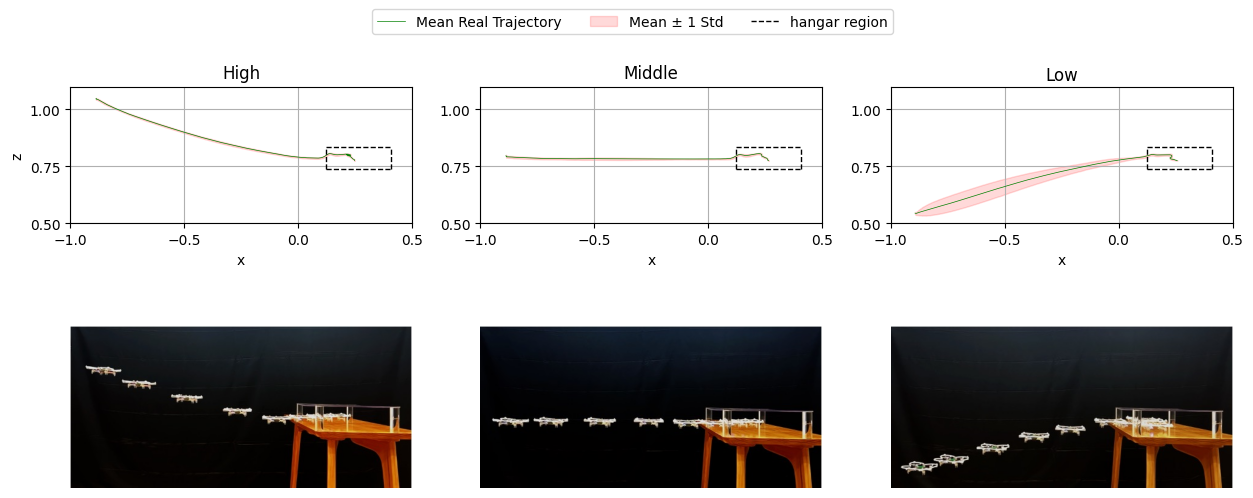

Plot saved to pdf_trajectory_plot.pdf


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import uav_trajectory

def plot_hangar_box(ax: plt.Axes, style = 'k--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741, 0.834
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'hangar region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right

def load_filtered_data(file_path, x_start=-0.870):
    ''' Load and filter data from a CSV file.'''
    df = pd.read_csv(file_path, header=None, skiprows=1)
    t_start = df[0].iloc[-1]
    df = df.iloc[:-1]
    df = df[df[0] > t_start]
    df = df[df[1] > x_start]
    # df = df[(df[1] > x_start) & (df[0] > t_start)]
    return df

def load_and_filter_trajectories(file_pattern, x_start=-0.90):
    '''
    Load and filter trajectory data from CSV files.
    
    Args:
        file_pattern (str): Glob pattern for CSV files (e.g., './data/middle/*.csv').
        x_start (float): Threshold for filtering x values.
    
    Returns:
        list: Lists of t, x, z arrays for each valid trajectory.
    '''
    all_t, all_x, all_z = [], [], []
    
    for csv_file in glob.glob(file_pattern):
        try:
            df = load_filtered_data(csv_file, x_start=x_start)
            
            if df.empty:
                print(f"{csv_file} -> Empty data, skipping")
                continue

            t = df[0].to_numpy() - df[0].iloc[0]  # Align time to 0
            x = df[1].to_numpy()
            z = df[3].to_numpy()
            all_t.append(t)
            all_x.append(x)
            all_z.append(z)

        except Exception as e:
            print(f"Error processing {csv_file}: {e}")
            continue
            
    return all_t, all_x, all_z

def interpolate_trajectories(all_t, all_x, all_z, num_points=500):
    '''
    Interpolate trajectories to a common time grid and compute mean/std.
    
    Args:
        all_t (list): List of time arrays.
        all_x (list): List of x-coordinate arrays.
        all_z (list): List of z-coordinate arrays.
        num_points (int): Number of points for interpolation.
    
    Returns:
        tuple: Common time grid, mean and std for x and z.
    '''
    t_min = max(t[0] for t in all_t)
    t_max = min(t[-1] for t in all_t)
    t_common = np.linspace(t_min, t_max, num_points)
    
    x_interp_all = [np.interp(t_common, t, x) for t, x in zip(all_t, all_x)]
    z_interp_all = [np.interp(t_common, t, z) for t, z in zip(all_t, all_z)]
    
    x_interp_all = np.array(x_interp_all)
    z_interp_all = np.array(z_interp_all)
    
    x_mean = np.mean(x_interp_all, axis=0)
    x_std = np.std(x_interp_all, axis=0)
    z_mean = np.mean(z_interp_all, axis=0)
    z_std = np.std(z_interp_all, axis=0)
    
    return t_common, x_mean, x_std, z_mean, z_std

def plot_waypoints(ax: plt.Axes, waypoints_path: str, x_start: float = -0.877):
    '''
    Plot waypoints from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        waypoints_path (str): Path to the waypoints CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    waypoints = np.loadtxt(waypoints_path, delimiter=",")
    mask = waypoints[:, 0] > x_start
    ax.scatter(waypoints[mask, 0], waypoints[mask, 2], c="red", marker="o", s=20, label="Waypoints")


def plot_polynomial_trajectory(ax: plt.Axes, trajectory_path: str, x_start: float = -0.877, style: str = "b-", label: str = ""):
    '''
    Plot the commanded trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        trajectory_path (str): Path to the trajectory CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    traj = uav_trajectory.Trajectory()
    traj.loadcsv(trajectory_path)
    ts = np.arange(0, traj.duration, 0.01)
    evals = np.empty((len(ts), 15))
    for t, i in zip(ts, range(0, len(ts))):
        e = traj.eval(t)
        evals[i, 0:3] = e.pos
        evals[i, 3:6] = e.vel
        evals[i, 6:9] = e.acc
        evals[i, 9:12] = e.omega
        evals[i, 12] = e.yaw
        evals[i, 13] = e.roll
        evals[i, 14] = e.pitch
    mask = evals[:, 0] > x_start
    ax.plot(evals[mask, 0], evals[mask, 2], style,label="Commanded trajectory", color="blue", linewidth=0.5)

def plot_actual_trajectory(ax: plt.Axes, csv_file: str, x_start: float = -0.877):
    '''
    Plot the actual trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        csv_file (str): Path to the actual trajectory CSV file.
        x_start (float): Value threshold for filtering the trajectory data.
    '''
    for i, csv_file in enumerate(glob.glob(csv_file)):
        df = load_filtered_data(csv_file, x_start)
        if i == 0:
            ax.plot(df[1], df[3], color='g', alpha=0.5, label='Actual trajectories')
        else:
            ax.plot(df[1], df[3], color='g', alpha=0.5, label='_nolegend_')


if __name__ == '__main__':
     
    x_start = -0.90
    num_points = 500

    file_folder_high = './data/varying_height/high/*.csv'
    file_folder_middle = './data/varying_height/middle/*.csv'
    file_folder_low = './data/varying_height/low/*.csv'

    # Load and filter trajectories
    all_t_high, all_x_high, all_z_high = load_and_filter_trajectories(file_folder_high, x_start)
    all_t_middle, all_x_middle, all_z_middle = load_and_filter_trajectories(file_folder_middle, x_start)
    all_t_low, all_x_low, all_z_low = load_and_filter_trajectories(file_folder_low, x_start)

    # Interpolate trajectories to a common time grid and compute mean/std
    t_common_high, x_mean_high, x_std_high, z_mean_high, z_std_high = interpolate_trajectories(all_t_high, all_x_high, all_z_high, num_points)
    t_common_middle, x_mean_middle, x_std_middle, z_mean_middle, z_std_middle = interpolate_trajectories(all_t_middle, all_x_middle, all_z_middle, num_points)
    t_common_low, x_mean_low, x_std_low, z_mean_low, z_std_low = interpolate_trajectories(all_t_low, all_x_low, all_z_low, num_points)



    fig, axs = plt.subplots(2, 3, figsize = (15,6))


    # =======================================================
    # High 
    # =======================================================

    axs[0,0].plot(x_mean_high, z_mean_high, color='g', label='Mean Real Trajectory', linewidth=0.5)
    axs[0,0].fill_between(x_mean_high, z_mean_high - z_std_high, z_mean_high + z_std_high, color='red', alpha=0.15, label='Mean ± 1 Std')

    # # Plot waypoints
    # waypoints_path = "./data/waypoints/final_high.csv"
    # plot_waypoints(axs[0,0], waypoints_path, x_start=x_start)

    # # Plot commanded trajectory
    # cmd_traj_path = "./data/trajectories/final_high_traj.csv"
    # plot_trajectory(axs[0,0], cmd_traj_path, x_start)

    # # Plot desired trajectory
    # desired_traj_path = "./data/trajectories/comd_high_traj.csv"
    # plot_polynomial_trajectory(axs[0, 0], desired_traj_path, x_start)

    axs[0,0].set_title('High')
    axs[0,0].set_xlabel('x')
    axs[0,0].set_ylabel('z')
    axs[0,0].grid(True)
    axs[0,0].set_xlim(-1.0, 0.5)
    axs[0,0].set_ylim(0.5, 1.1)
    # axs[0,0].legend(loc='upper right')
    # axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=3)
    plot_hangar_box(axs[0,0])
    axs[0,0].set_aspect('equal')
    axs[0,0].set_xticks(np.arange(-1.0, 0.6, 0.5))
    axs[0,0].set_yticks(np.arange(0.5, 1.1, 0.25))
    # # axs[0,0].set_aspect('equal', 'box')

 
    # =======================================================
    # Middle
    # =======================================================

    axs[0,1].plot(x_mean_middle, z_mean_middle, color='g', label='Mean Real Trajectory', linewidth=0.5) 
    axs[0,1].fill_between(x_mean_middle, z_mean_middle - z_std_middle, z_mean_middle + z_std_middle, color='red', alpha=0.15, label='Mean ± 1 Std')

    # # Plot waypoints
    # waypoints_path = "./data/waypoints/final_middle.csv"
    # plot_waypoints(axs[0,1], waypoints_path, x_start=x_start)

    # # Plot commanded trajectory
    # cmd_traj_path = "./data/trajectories/final_middle_traj.csv"
    # plot_trajectory(axs[0,1], cmd_traj_path, x_start)

    # # Plot desired trajectory
    # desired_traj_path = "./data/trajectories/comd_middle_traj.csv"
    # plot_polynomial_trajectory(axs[0,1], desired_traj_path, x_start)
    
    axs[0,1].set_title('Middle')
    axs[0,1].set_xlabel('x')
    axs[0,1].grid(True)
    axs[0,1].set_xlim(-1.0, 0.5)
    axs[0,1].set_ylim(0.5, 1.1)
    # axs[0,1].legend(loc='upper right')
    # axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=3)
    plot_hangar_box(axs[0,1])
    axs[0,1].set_aspect('equal')
    axs[0,1].set_xticks(np.arange(-1.0, 0.6, 0.5))
    axs[0,1].set_yticks(np.arange(0.5, 1.1, 0.25))
    # axs[0,1].set_aspect('equal', 'box')


    # =======================================================
    # Low
    # =======================================================

    axs[0,2].plot(x_mean_low, z_mean_low, color='g', label='Mean Real Trajectory', linewidth=0.5)
    axs[0,2].fill_between(x_mean_low, z_mean_low - z_std_low, z_mean_low + z_std_low, color='red', alpha=0.15, label='Mean ± 1 Std')

    # # Plot waypoints
    # waypoints_path = "./data/waypoints/final_low.csv"
    # plot_waypoints(axs[0,2], waypoints_path, x_start=x_start)

    # # Plot commanded trajectory
    # cmd_traj_path = "./data/trajectories/final_low_traj.csv"
    # plot_trajectory(axs[0,2], cmd_traj_path, x_start)

    # # Plot desired trajectory
    # desired_traj_path = "./data/trajectories/comd_low_traj.csv"
    # plot_polynomial_trajectory(axs[0,2], desired_traj_path, x_start)

    axs[0,2].set_title('Low',y = 0.99)
    axs[0,2].set_xlabel('x')
    axs[0,2].grid(True)
    axs[0,2].set_xlim(-1.0, 0.5)
    axs[0,2].set_ylim(0.5, 1.1)  
    # axs[0,2].legend(loc='upper right')
    # axs[0,2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=3)
    plot_hangar_box(axs[0,2])
    axs[0,2].set_aspect('equal')
    axs[0,2].set_xticks(np.arange(-1.0, 0.6, 0.5))
    axs[0,2].set_yticks(np.arange(0.5, 1.1, 0.25))
    # axs[0,2].set_aspect('equal', 'box')



    img_paths = ['./data/imgs/high_snapshot.jpg', './data/imgs/middle_snapshot.jpg', './data/imgs/low_snapshot.jpg']  # 替换为你的图片路径
    for i, img_path in enumerate(img_paths):
        img = plt.imread(img_path)
        axs[1, i].imshow(img)
        axs[1, i].axis('off')
        # axs[1, i].set_title(f"Snapshot {i+1}")

    # 只收集第一行轨迹子图的 legend, 对于2行
    handles, labels = [], []
    for ax in axs[0]:  # 只遍历第一行的每个子图
        for h, l in zip(*ax.get_legend_handles_labels()):
            if l not in labels:
                handles.append(h)
                labels.append(l)

    # 添加全局 legend
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=3)


    # # 收集所有 handles 和 labels 对于1行
    # handles, labels = [], []
    # for ax in axs:
    #     for h, l in zip(*ax.get_legend_handles_labels()):
    #         if l not in labels:
    #             handles.append(h)
    #             labels.append(l)
    
    # # 添加全局 legend
    # fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.92), ncol=3)
    
    # # suptitle 稍微往上移
    # plt.suptitle('Mean and Std of z vs x for Different Trajectory Heights', fontsize=16, y=1.03)
    # plt.tight_layout(rect=[0, 0, 1, 0.90])  # 留出 legend 空间

    # plt.tight_layout()
    # plt.suptitle('Mean and Std of z vs x for Different Trajectory Heights', fontsize=16)
    # plt.subplots_adjust(hspace=0.0,)  # Adjust top to make room for the title
    # plt.show() 

    # Save as PDF
    output_file = 'pdf_trajectory_plot.pdf'
    dpi = 300
    plt.savefig(output_file, format='pdf', dpi=dpi, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Plot saved to {output_file}")


500
107
RMSE: 0.030236089196404428


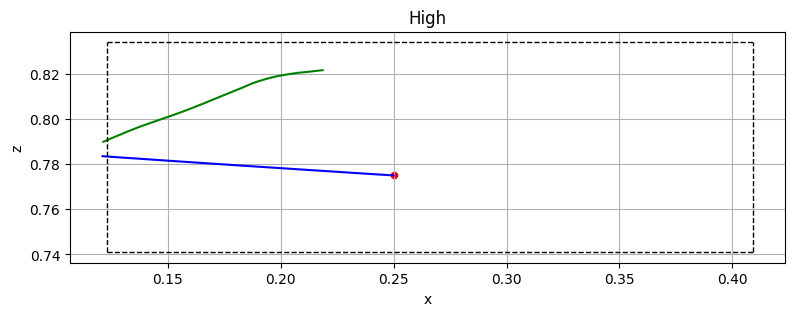

Plot saved to pdf_RMSE.pdf


In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import uav_trajectory

def plot_hangar_box(ax: plt.Axes, style = 'k--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741, 0.834
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'hangar region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right

def load_filtered_data(file_path, x_start=-0.870, x_end = 0.25 ):
    ''' Load and filter data from a CSV file.'''
    df = pd.read_csv(file_path, header=None, skiprows=1)
    t_start = df[0].iloc[-1]
    df = df.iloc[:-1]
    df = df[df[0] > t_start]
    df = df[(df[1] >= x_start) & (df[1] <= x_end)]
    # df = df[(df[1] > x_start) & (df[0] > t_start)]
    return df

def load_and_filter_trajectories(file_pattern, x_start=-0.90, x_end = 0.25):
    '''
    Load and filter trajectory data from CSV files.
    
    Args:
        file_pattern (str): Glob pattern for CSV files (e.g., './data/middle/*.csv').
        x_start (float): Threshold for filtering x values.
    
    Returns:
        list: Lists of t, x, z arrays for each valid trajectory.
    '''
    all_t, all_x, all_z = [], [], []
    
    for csv_file in glob.glob(file_pattern):
        try:
            df = load_filtered_data(csv_file, x_start=x_start, x_end = x_end)
            
            if df.empty:
                print(f"{csv_file} -> Empty data, skipping")
                continue

            t = df[0].to_numpy() - df[0].iloc[0]  # Align time to 0
            x = df[1].to_numpy()
            z = df[3].to_numpy()
            all_t.append(t)
            all_x.append(x)
            all_z.append(z)

        except Exception as e:
            print(f"Error processing {csv_file}: {e}")
            continue
            
    return all_t, all_x, all_z

def interpolate_trajectories(all_t, all_x, all_z, step = 0.01, num_points=500):
    '''
    Interpolate trajectories to a common time grid and compute mean/std.
    
    Args:
        all_t (list): List of time arrays.
        all_x (list): List of x-coordinate arrays.
        all_z (list): List of z-coordinate arrays.
        num_points (int): Number of points for interpolation.
    
    Returns:
        tuple: Common time grid, mean and std for x and z.
    '''
    t_min = max(t[0] for t in all_t)
    t_max = min(t[-1] for t in all_t)
    t_common = np.linspace(t_min, t_max, num_points)
    # t_common = np.arange(t_min, t_max, step)
    
    x_interp_all = [np.interp(t_common, t, x) for t, x in zip(all_t, all_x)]
    z_interp_all = [np.interp(t_common, t, z) for t, z in zip(all_t, all_z)]
    
    x_interp_all = np.array(x_interp_all)
    z_interp_all = np.array(z_interp_all)
    
    x_mean = np.mean(x_interp_all, axis=0)
    x_std = np.std(x_interp_all, axis=0)
    z_mean = np.mean(z_interp_all, axis=0)
    z_std = np.std(z_interp_all, axis=0)
    
    return t_common, x_mean, x_std, z_mean, z_std

def plot_waypoints(ax: plt.Axes, waypoints_path: str, val_filter: float = -0.877):
    '''
    Plot waypoints from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        waypoints_path (str): Path to the waypoints CSV file.
        val_filter (float): Value threshold for filtering the trajectory data.
    '''
    waypoints = np.loadtxt(waypoints_path, delimiter=",")
    mask = waypoints[:, 0] > val_filter
    ax.scatter(waypoints[mask, 0], waypoints[mask, 2], c="red", marker="o", s=20, label="Waypoints")


def plot_polynomial_trajectory(ax: plt.Axes, trajectory_path: str, val_filter: float = -0.877, style: str = "b-", label: str = ""):
    '''
    Plot the commanded trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        trajectory_path (str): Path to the trajectory CSV file.
        val_filter (float): Value threshold for filtering the trajectory data.
    '''
    traj = uav_trajectory.Trajectory()
    traj.loadcsv(trajectory_path)
    ts = np.arange(0, traj.duration, 0.01)
    evals = np.empty((len(ts), 15))
    for t, i in zip(ts, range(0, len(ts))):
        e = traj.eval(t)
        evals[i, 0:3] = e.pos
        evals[i, 3:6] = e.vel
        evals[i, 6:9] = e.acc
        evals[i, 9:12] = e.omega
        evals[i, 12] = e.yaw
        evals[i, 13] = e.roll
        evals[i, 14] = e.pitch
    mask = evals[:, 0] > val_filter
    ax.plot(evals[mask, 0], evals[mask, 2], style,label="Commanded trajectory", linewidth=0.5)

def plot_actual_trajectory(ax: plt.Axes, csv_file: str, val_filter: float = -0.877):
    '''
    Plot the actual trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        csv_file (str): Path to the actual trajectory CSV file.
        val_filter (float): Value threshold for filtering the trajectory data.
    '''
    for i, csv_file in enumerate(glob.glob(csv_file)):
        df = load_filtered_data(csv_file, VAL_FILTER)
        if i == 0:
            ax.plot(df[1], df[3], color='g', alpha=0.5, label='Actual trajectories')
        else:
            ax.plot(df[1], df[3], color='g', alpha=0.5, label='_nolegend_')


if __name__ == '__main__':
     
    x_start = 0.12
    x_end= 0.25
    step = 0.01

    # file_folder_high = './data/ablation/PPPC/*.csv'
    pppc = './data/ablation/PPPC/*.csv'
    ppbc = './data/ablation/PPBC/*.csv'
    bppc = './data/ablation/BPPC/*.csv'
    file_folder_high = './data/ablation/BPBC/*.csv'

    # Load and filter trajectories
    all_t_high, all_x_high, all_z_high = load_and_filter_trajectories(file_folder_high, x_start,x_end)

    # Interpolate trajectories to a common time grid and compute mean/std
    t_common_high, x_mean_high, x_std_high, z_mean_high, z_std_high = interpolate_trajectories(all_t_high, all_x_high, all_z_high, step)





    fig, axs = plt.subplots(1, 1, figsize = (15,3))


    print(len(t_common_high))
    # print(t_common_high)
    # print(x_mean_high)

    axs.plot(x_mean_high, z_mean_high, color='g', label='Mean Real Trajectory', linewidth=1.5)


    trajectory_path = './data/ablation/trajectories/baseline_traj.csv'
    traj = uav_trajectory.Trajectory()
    traj.loadcsv(trajectory_path)
    ts = np.arange(0, traj.duration, 0.01)
    # ts = np.linspace(0, traj.duration, len(t_common_high))
    # print(len(ts))
    evals = np.empty((len(ts), 15))
    for t, i in zip(ts, range(0, len(ts))):
        e = traj.eval(t)
        evals[i, 0:3] = e.pos
        evals[i, 3:6] = e.vel
        evals[i, 6:9] = e.acc
        evals[i, 9:12] = e.omega
        evals[i, 12] = e.yaw
        evals[i, 13] = e.roll
        evals[i, 14] = e.pitch
    mask = (evals[:, 0] >=  x_start) & (evals[:, 0] <= x_end)
    axs.plot(evals[mask, 0], evals[mask, 2],label="Commanded trajectory", color="blue", linewidth=1.5)
    print(len(evals[mask, 0]))
    # print(ts[mask])
    # print(evals[mask,0])

    # ...existing code...

    # 假设 x_mean_high, z_mean_high 是第一组，evals[mask, 0], evals[mask, 2] 是第二组
    x1, z1 = x_mean_high, z_mean_high
    x2, z2 = evals[mask, 0], evals[mask, 2]

    # 1. 取x的交集区间
    x_min = max(x1.min(), x2.min())
    x_max = min(x1.max(), x2.max())
    # print(x_min,x_max)
    x_common = np.linspace(x_min, x_max, 100)  # 200可以根据需要调整

    # 2. 插值
    z1_interp = np.interp(x_common, x1, z1) # real
    z2_interp = np.interp(x_common, x2, z2) # desired
    # print(z1_interp)
    # print('\n')
    # print(z2_interp)


    # 3. 计算RMSE
    rmse = np.sqrt(np.mean((z1_interp - z2_interp) ** 2))
    print("RMSE:", rmse)
    # ...existing code...

    # Plot waypoints
    waypoints_path = "./data/ablation/waypoints/baseline.csv"
    plot_waypoints(axs, waypoints_path, val_filter=x_start)


    axs.set_title('High')
    axs.set_xlabel('x')
    axs.set_ylabel('z')
    axs.grid(True)

    plot_hangar_box(axs)
    axs.set_aspect('equal')



    # Save as PDF
    output_file = 'pdf_RMSE.pdf'
    dpi = 300
    plt.savefig(output_file, format='pdf', dpi=dpi, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Plot saved to {output_file}")
 



--- Processing PPPC trajectories ---
RMSE for PPPC vs Baseline: 0.021804

--- Processing PPBC trajectories ---
RMSE for PPBC vs Baseline: 0.027066

--- Processing BPPC trajectories ---
RMSE for BPPC vs Baseline: 0.030001

--- Processing BPBC trajectories ---
RMSE for BPBC vs Baseline: 0.035064

--- Final RMSE Results ---
PPPC: 0.021804
PPBC: 0.027066
BPPC: 0.030001
BPBC: 0.035064


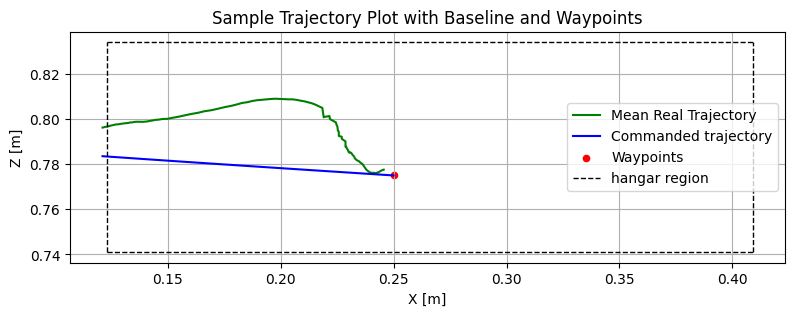

Plot saved to pdf_simple_RMSE_plot.pdf


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import uav_trajectory

def plot_hangar_box(ax: plt.Axes, style = 'k--', line_width = 1):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741, 0.834
    ax.plot([x_min, x_max], [z_min, z_min], style, linewidth = line_width, label = 'hangar region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], style, linewidth = line_width)  # Top
    ax.plot([x_min, x_min], [z_min, z_max], style, linewidth = line_width)  # Left
    ax.plot([x_max, x_max], [z_min, z_max], style, linewidth = line_width)  # Right

def load_filtered_data(file_path, x_start=-0.870, x_end = 0.25 ):
    ''' Load and filter data from a CSV file.'''
    df = pd.read_csv(file_path, header=None, skiprows=1)
    t_start = df[0].iloc[-1]
    df = df.iloc[:-1]
    df = df[df[0] > t_start]
    df = df[(df[1] >= x_start) & (df[1] <= x_end)]
    return df

def load_and_filter_trajectories(file_pattern, x_start=-0.90, x_end = 0.25):
    '''
    Load and filter trajectory data from CSV files.
    
    Args:
        file_pattern (str): Glob pattern for CSV files (e.g., './data/middle/*.csv').
        x_start (float): Start x value for filtering.
        x_end (float): End x value for filtering.
    
    Returns:
        tuple: Lists of t, x, z arrays for each valid trajectory.
    '''
    all_t, all_x, all_z = [], [], []
    
    for csv_file in glob.glob(file_pattern):
        try:
            df = load_filtered_data(csv_file, x_start=x_start, x_end = x_end)
            
            if df.empty:
                print(f"Warning: {csv_file} -> Empty data after filtering, skipping.")
                continue

            # Ensure x is sorted for interpolation
            sort_indices = np.argsort(df[1].to_numpy())
            t = (df[0].to_numpy() - df[0].iloc[0])[sort_indices]  # Align time to 0 and sort
            x = df[1].to_numpy()[sort_indices]
            z = df[3].to_numpy()[sort_indices]
            
            all_t.append(t)
            all_x.append(x)
            all_z.append(z)

        except Exception as e:
            print(f"Error processing {csv_file}: {e}")
            continue
            
    return all_t, all_x, all_z

def plot_waypoints(ax: plt.Axes, waypoints_path: str, val_filter: float = -0.877):
    '''
    Plot waypoints from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        waypoints_path (str): Path to the waypoints CSV file.
        val_filter (float): Value threshold for filtering the trajectory data.
    '''
    waypoints = np.loadtxt(waypoints_path, delimiter=",")
    mask = waypoints[:, 0] > val_filter
    ax.scatter(waypoints[mask, 0], waypoints[mask, 2], c="red", marker="o", s=20, label="Waypoints")


def plot_polynomial_trajectory(ax: plt.Axes, trajectory_path: str, x_start: float = -0.877, x_end: float = 0.25, style: str = "b-", label: str = ""):
    '''
    Plot the commanded trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        trajectory_path (str): Path to the trajectory CSV file.
        x_start (float): Start x value for filtering.
        x_end (float): End x value for filtering.
    Returns:
        tuple: x and z coordinates of the filtered commanded trajectory.
    '''
    traj = uav_trajectory.Trajectory()
    traj.loadcsv(trajectory_path)
    ts = np.arange(0, traj.duration, 0.01)
    evals = np.empty((len(ts), 15))
    for t, i in zip(ts, range(0, len(ts))):
        e = traj.eval(t)
        evals[i, 0:3] = e.pos

    # Sort by x values for correct interpolation later
    sort_indices = np.argsort(evals[:, 0])
    x_data = evals[sort_indices, 0]
    z_data = evals[sort_indices, 2]

    # Filter by x-range
    mask = (x_data >= x_start) & (x_data <= x_end)
    
    ax.plot(x_data[mask], z_data[mask], style, label=label, linewidth=1.5)
    return x_data[mask], z_data[mask] # Return filtered x and z for baseline

def plot_actual_trajectory(ax: plt.Axes, csv_file: str, x_start: float = -0.877, x_end: float = 0.25):
    '''
    Plot the actual trajectory from a CSV file on the given axes.
    Args:
        ax (plt.Axes): The axes to plot on.
        csv_file (str): Path to the actual trajectory CSV file.
        x_start (float): Start x value for filtering.
        x_end (float): End x value for filtering.
    '''
    for i, csv_file in enumerate(glob.glob(csv_file)):
        df = load_filtered_data(csv_file, x_start, x_end)
        if i == 0:
            ax.plot(df[1], df[3], color='g', alpha=0.5, label='Actual trajectories', linewidth= 1.0)
        else:
            ax.plot(df[1], df[3], color='g', alpha=0.5, label='_nolegend_',linewidth= 1.0)


## Main Execution Block with In-Line RMSE Calculation

if __name__ == '__main__':
    # Define common parameters for RMSE calculation
    x_start_range = 0.12
    x_end_range = 0.25
    num_interpolation_points = 500 # Number of points for common x-grid

    # Define trajectory paths
    baseline_path = './data/ablation/trajectories/baseline_traj.csv'
    
    # --- Load and prepare the BASELINE (commanded) trajectory ---
    traj_baseline = uav_trajectory.Trajectory()
    traj_baseline.loadcsv(baseline_path)
    ts_baseline = np.arange(0, traj_baseline.duration, 0.01)
    evals_baseline = np.empty((len(ts_baseline), 15))
    for t_b, i_b in zip(ts_baseline, range(len(ts_baseline))):
        e_b = traj_baseline.eval(t_b)
        evals_baseline[i_b, 0:3] = e_b.pos

    # Filter and sort baseline data by x-range
    # Sort by x values for correct interpolation later
    sort_indices_baseline = np.argsort(evals_baseline[:, 0])
    x_baseline_raw = evals_baseline[sort_indices_baseline, 0]
    z_baseline_raw = evals_baseline[sort_indices_baseline, 2]
    
    mask_baseline = (x_baseline_raw >= x_start_range) & (x_baseline_raw <= x_end_range)
    x_baseline_filtered = x_baseline_raw[mask_baseline]
    z_baseline_filtered = z_baseline_raw[mask_baseline]

    if len(x_baseline_filtered) < 2:
        print(f"Error: Baseline trajectory has insufficient data in the specified range ({x_start_range} to {x_end_range}).")
        x_baseline_filtered = np.array([]) # Ensure it's an empty array
        z_baseline_filtered = np.array([])

    # --- Prepare a list of trajectory patterns to process ---
    trajectory_sets = {
        'PPPC': './data/ablation/PPPC/*.csv',
        'PPBC': './data/ablation/PPBC/*.csv',
        'BPPC': './data/ablation/BPPC/*.csv',
        'BPBC': './data/ablation/BPBC/*.csv'
    }

    results_rmse = {}

    for name, pattern in trajectory_sets.items():
        print(f"\n--- Processing {name} trajectories ---")
        
        all_t_actual, all_x_actual, all_z_actual = load_and_filter_trajectories(pattern, x_start_range, x_end_range)

        if not all_t_actual or len(x_baseline_filtered) < 2:
            results_rmse[name] = np.nan
            print(f"Skipping RMSE for {name} due to insufficient data.")
            continue
            
        # Determine common x-range for interpolation between actual and baseline
        # Take min of max_x and max of min_x for all actual trajectories
        actual_x_mins = [x_arr[0] for x_arr in all_x_actual if len(x_arr) > 0]
        actual_x_maxs = [x_arr[-1] for x_arr in all_x_actual if len(x_arr) > 0]
        
        # Take the intersection of ranges
        common_x_min_interp = max(x_baseline_filtered.min(), min(actual_x_mins) if actual_x_mins else x_baseline_filtered.min())
        common_x_max_interp = min(x_baseline_filtered.max(), max(actual_x_maxs) if actual_x_maxs else x_baseline_filtered.max())

        if common_x_min_interp >= common_x_max_interp:
            print(f"Warning: No overlapping x-range for {name} and baseline for interpolation. Skipping RMSE.")
            results_rmse[name] = np.nan
            continue

        x_common_grid = np.linspace(common_x_min_interp, common_x_max_interp, num_interpolation_points)

        # Interpolate each actual trajectory's z values onto the common x-grid
        z_actual_interp_list = []
        for i in range(len(all_x_actual)):
            z_actual_interp_list.append(np.interp(x_common_grid, all_x_actual[i], all_z_actual[i]))
        
        # Calculate the mean Z for actual trajectories
        z_actual_mean = np.mean(z_actual_interp_list, axis=0)

        # Interpolate baseline trajectory to the common x-grid
        z_baseline_interp = np.interp(x_common_grid, x_baseline_filtered, z_baseline_filtered)

        # Calculate RMSE
        rmse = np.sqrt(np.mean((z_actual_mean - z_baseline_interp) ** 2))
        results_rmse[name] = rmse
        print(f"RMSE for {name} vs Baseline: {rmse:.6f}")

    # --- Print all results ---
    print("\n--- Final RMSE Results ---")
    for name, rmse_val in results_rmse.items():
        print(f"{name}: {rmse_val:.6f}" if not np.isnan(rmse_val) else f"{name}: N/A (Insufficient Data)")

    # --- Plotting section (remains mostly the same for illustration) ---
    fig, axs = plt.subplots(1, 1, figsize = (15,3))

    # Load and plot one of the mean actual trajectories (e.g., 'PPPC' or 'high')
    # For a general plot, let's plot the 'high' data as you had before.
    # If you want to plot one of the ablation sets, change the `file_folder_high` variable.
    file_folder_for_plot = './data/high/*.csv' # or use pppc_path, etc.
    all_t_plot, all_x_plot, all_z_plot = load_and_filter_trajectories(file_folder_for_plot, x_start_range, x_end_range)
    
    if all_t_plot:
        # For plotting, interpolate to a common time grid (or just plot individual trajectories with alpha)
        # For mean trajectory plotting, we need time-based interpolation results.
        # This part of the code is different from the RMSE calculation's x-based interpolation.
        try:
            # First, find overall min and max time across all_t_plot for a common time base
            min_t_end_plot = min(t_arr[-1] for t_arr in all_t_plot if len(t_arr) > 0)
            max_t_start_plot = max(t_arr[0] for t_arr in all_t_plot if len(t_arr) > 0)
            if min_t_end_plot <= max_t_start_plot:
                 print("Warning: No common time overlap for plotting mean trajectory. Plotting individual actual trajectories.")
                 # Fallback to plotting individual trajectories if common time base is problematic
                 for i in range(len(all_t_plot)):
                     axs.plot(all_x_plot[i], all_z_plot[i], color='g', alpha=0.5, label='Actual trajectories' if i == 0 else '_nolegend_', linewidth=1.0)
            else:
                t_common_plot = np.linspace(max_t_start_plot, min_t_end_plot, num_interpolation_points)
                x_interp_plot_all = [np.interp(t_common_plot, t_arr, x_arr) for t_arr, x_arr in zip(all_t_plot, all_x_plot)]
                z_interp_plot_all = [np.interp(t_common_plot, t_arr, z_arr) for t_arr, z_arr in zip(all_t_plot, all_z_plot)]
                
                x_mean_plot = np.mean(x_interp_plot_all, axis=0)
                z_mean_plot = np.mean(z_interp_plot_all, axis=0)
                axs.plot(x_mean_plot, z_mean_plot, color='g', label='Mean Real Trajectory', linewidth=1.5)
        except Exception as e:
            print(f"Could not plot mean 'Actual' trajectories: {e}. Attempting to plot individual trajectories.")
            for i in range(len(all_t_plot)):
                axs.plot(all_x_plot[i], all_z_plot[i], color='g', alpha=0.5, label='Actual trajectories' if i == 0 else '_nolegend_', linewidth=1.0)
    else:
        print(f"No valid actual trajectories found for plotting from {file_folder_for_plot}")


    # Plot the baseline commanded trajectory (uses the pre-loaded x_baseline_filtered, z_baseline_filtered)
    axs.plot(x_baseline_filtered, z_baseline_filtered, label="Commanded trajectory", color="blue", linewidth=1.5)

    # Plot waypoints
    waypoints_path = "./data/ablation/waypoints/baseline.csv"
    plot_waypoints(axs, waypoints_path, val_filter=x_start_range)

    axs.set_title('Sample Trajectory Plot with Baseline and Waypoints')
    axs.set_xlabel('X [m]')
    axs.set_ylabel('Z [m]')
    axs.grid(True)
    plot_hangar_box(axs)
    axs.set_aspect('equal')
    axs.legend()

    # Save as PDF
    output_file = 'pdf_simple_RMSE_plot.pdf' # Changed filename to avoid overwriting previous plot
    dpi = 300
    plt.savefig(output_file, format='pdf', dpi=dpi, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Plot saved to {output_file}")